## Cell type prediction by GDR

In this tutorial, we use a reference dataset to predict the cell type annotations of the query dataset. The cell type annotations of the query dataset are known, therefore our predictions can be verified and checked for accuracy.

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import os
from typing import Iterable, Union, Optional
import matplotlib.pyplot as plt
import anndata as ad
from sklearn import metrics
import seaborn as sns
from matplotlib import cm
from matplotlib import colors, colorbar
# from tqdm import tqdm
import logging
sc.set_figure_params(dpi=80,dpi_save=300, color_map='viridis',facecolor='white')
from matplotlib import rcParams
# To modify the default figure size, use rcParams.
rcParams['figure.figsize'] = 5, 5
rcParams['font.sans-serif'] = "Arial"
rcParams['font.family'] = "Arial"
sc.settings.verbosity = 3
sc.logging.print_header()

scanpy==1.10.3 anndata==0.10.8 umap==0.5.7 numpy==1.26.4 scipy==1.12.0 pandas==2.2.3 scikit-learn==1.5.2 statsmodels==0.14.4 igraph==0.11.8 louvain==0.8.2 pynndescent==0.5.13


In [2]:
path = '/home/vas744/Analysis/Python/Packages/PIASO'
import sys
sys.path.append(path)
import piaso

### Load the data

#### Load the reference dataset

We will use the 20k subsampled version of the Seattle Alzheimer’s Disease Brain Cell Atlas (SEA-AD) project dataset described in detail in [Gabitto et. al. (2024)](../references.html#cell1), as the reference dataset. We will be using the scRNA-seq data from the dataset in this tutorial. Please refer to the "Introduction to PIASO" tutorial to learn more about how it was preprocessed and normalized.

Download the subsampled, pre-processed dataset from Google Drive: https://drive.google.com/file/d/1pDBIgPvEO-sBuIMEhrvVhnf7tfU7H6Xy/view?usp=drive_link

The original data is available on https://portal.brain-map.org/explore/seattle-alzheimers-disease

In [4]:
data_dir = "/n/scratch/users/v/vas744/Data/Public/PIASO"

In [1]:
!/home/vas744/Software/gdrive files download --destination {data_dir} 1pDBIgPvEO-sBuIMEhrvVhnf7tfU7H6Xy

In [5]:
ref_adata=sc.read(data_dir + '/SEA-AD_RNA_MTG_subsample_excludeReference_20k_piaso.h5ad')
ref_adata.layers['log1p']=ref_adata.X
ref_adata

AnnData object with n_obs × n_vars = 20000 × 36601
    obs: 'sample_id', 'Neurotypical reference', 'Donor ID', 'Organism', 'Brain Region', 'Sex', 'Gender', 'Age at Death', 'Race (choice=White)', 'Race (choice=Black/ African American)', 'Race (choice=Asian)', 'Race (choice=American Indian/ Alaska Native)', 'Race (choice=Native Hawaiian or Pacific Islander)', 'Race (choice=Unknown or unreported)', 'Race (choice=Other)', 'specify other race', 'Hispanic/Latino', 'Highest level of education', 'Years of education', 'PMI', 'Fresh Brain Weight', 'Brain pH', 'Overall AD neuropathological Change', 'Thal', 'Braak', 'CERAD score', 'Overall CAA Score', 'Highest Lewy Body Disease', 'Total Microinfarcts (not observed grossly)', 'Total microinfarcts in screening sections', 'Atherosclerosis', 'Arteriolosclerosis', 'LATE', 'Cognitive Status', 'Last CASI Score', 'Interval from last CASI in months', 'Last MMSE Score', 'Interval from last MMSE in months', 'Last MOCA Score', 'Interval from last MOCA in mont

#### Load the query dataset

We will use a pre-processed Great Apes RNASeq data, particularly the human data subset as the query dataset for predicting cell types in this tutorial.

Download the dataset from: https://drive.google.com/file/d/1B2YbVWCuVIh0987ZdNieZKdZ138X6zTY/view

In [ ]:
!/home/vas744/Software/gdrive files download --overwrite --destination {data_dir} 1nF0iRTGFFQcEcM6hYcPptiYkxs65k2p4

In [6]:
aibs_query_adata = sc.read(data_dir + "/GreatApesMTG_RNA_integrated_raw_onlyOrthogonal_gdr_humanSubset_aibs.h5ad")
aibs_query_adata

AnnData object with n_obs × n_vars = 76560 × 14346
    obs: 'nCount_RNA', 'nFeature_RNA', 'sample_id', 'dataset', 'donor', 'species', 'tech', 'species_tech', 'neighborhood', 'layer', 'cluster', 'cluster_color', 'cross_species_cluster', 'cross_species_cluster_color', 'sex', 'donor_color', 'subclass', 'subclass_color', 'class', 'UMAP_1', 'UMAP_2', 'batch', 'Sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'pct_counts_ribo', 'Leiden'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable'
    uns: 'Leiden_colors', 'Sample_colors', 'hvg', 'leiden', 'log1p', 'neighbors', 'species_tech_colors', 'subclass_colors', 'umap'
    obsm: 'X_gdr', 'X_gdr_harmony', 'X_svd', 'X_umap', 'X_umap_gdr', 'X_umap_gdr_harmony', 'X_umap_published'
    layers: 'log1p', 'raw'
    obsp: 'connectivities', 'distances'

### Visualize with UMAPs

Reorder the query dataset categories to match the reference dataset categories

In [7]:
aibs_query_adata.obs['subclass']=aibs_query_adata.obs['subclass'].astype('category')
aibs_query_adata.obs['subclass']=aibs_query_adata.obs['subclass'].cat.reorder_categories(ref_adata.obs['Subclass'].cat.categories)

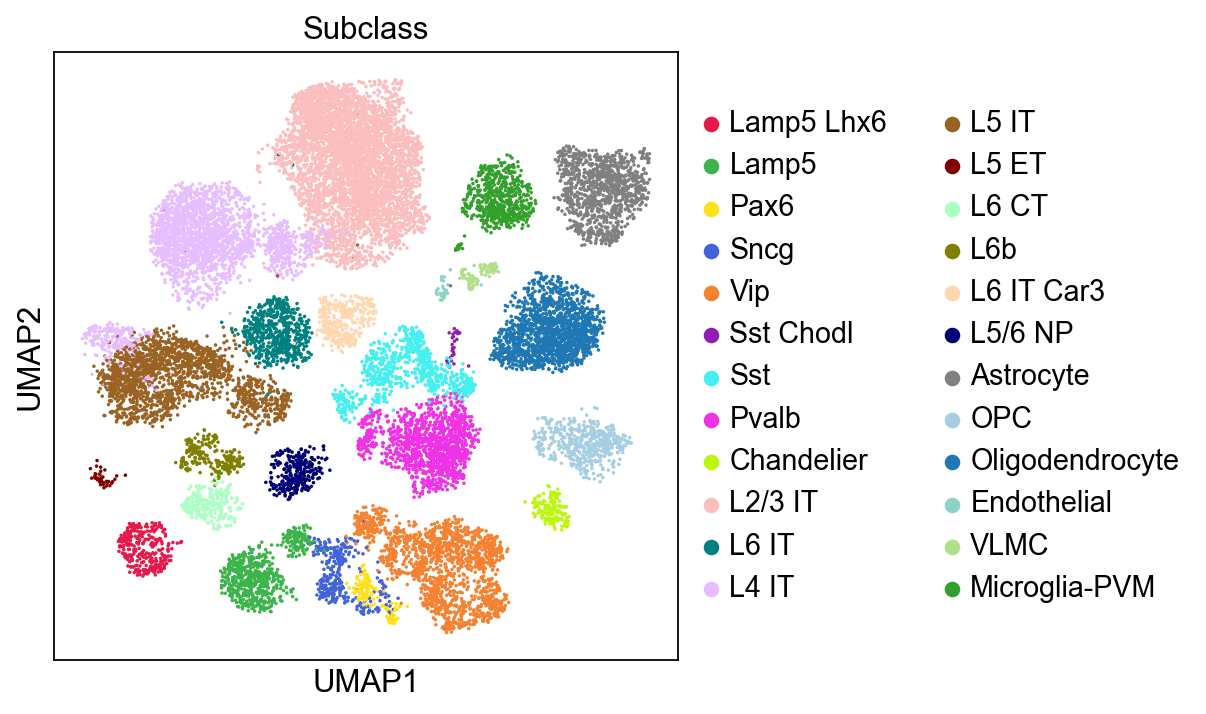

In [8]:
sc.pl.umap(ref_adata,
           color=['Subclass'],
           palette=piaso.pl.color.d_color4,
           cmap=pos_cmap,
           ncols=1,
           size=10,
           frameon=True)

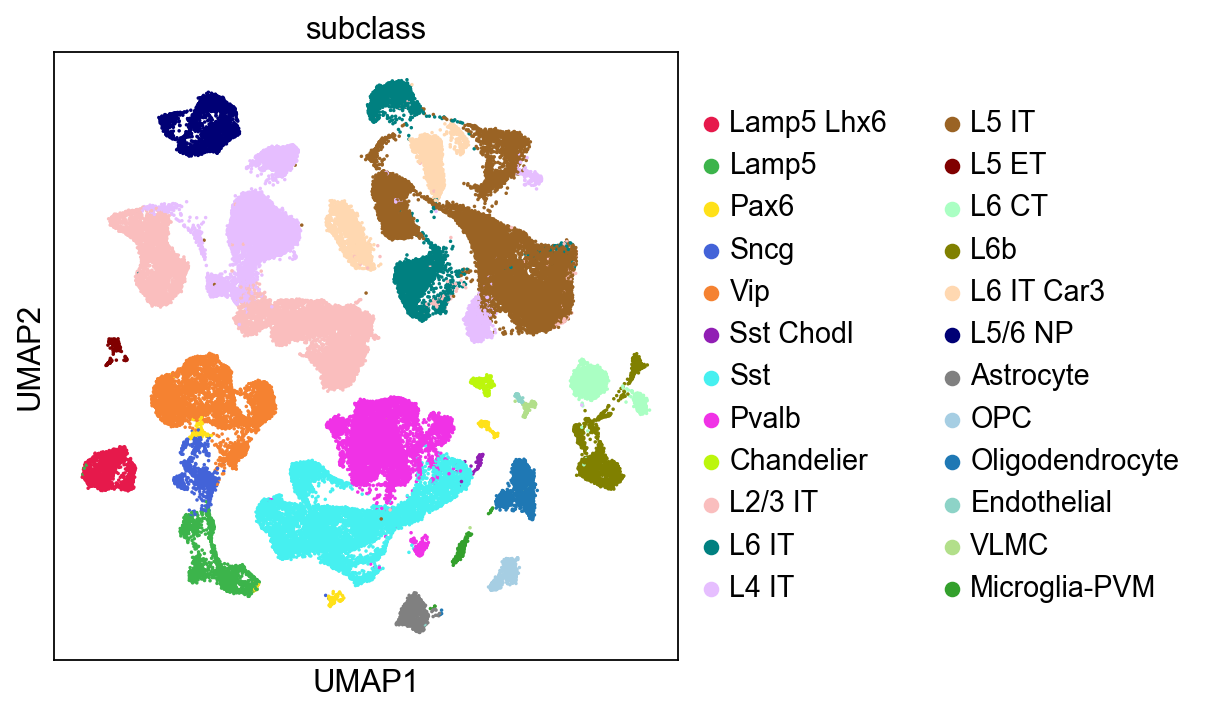

In [9]:
sc.pl.umap(aibs_query_adata,
           color=['subclass'],
           palette=piaso.pl.color.d_color4,
           cmap=pos_cmap,
           ncols=1,
           size=10,
           frameon=True)

### Cluster the query data

In [10]:
%%time
sc.tl.leiden(aibs_query_adata,resolution=0.2,key_added='Leiden',flavor="igraph",n_iterations=-1)

running Leiden clustering
    finished: found 26 clusters and added
    'Leiden', the cluster labels (adata.obs, categorical) (0:00:05)
CPU times: user 4.91 s, sys: 353 ms, total: 5.27 s
Wall time: 5.25 s


In [11]:
logging.getLogger('matplotlib.font_manager').disabled = True

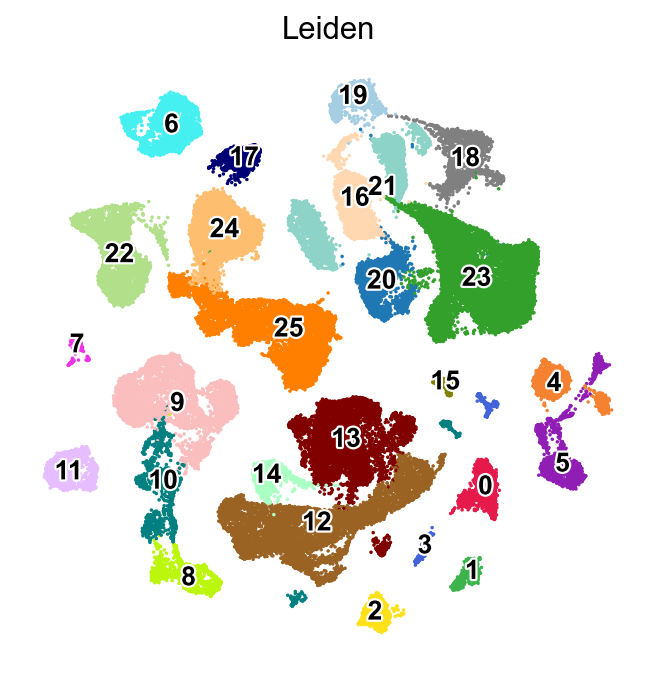

In [12]:
sc.pl.umap(aibs_query_adata,
           color=['Leiden'],
           palette=piaso.pl.color.d_color4,
           cmap=pos_cmap,
           legend_fontsize=12,
           legend_fontoutline=2,
           legend_loc='on data',
           ncols=1,
           size=10,
           frameon=False)

### Predict cell types by GDR

In [13]:
piaso.tl.predictCellTypeByGDR(
    aibs_query_adata,
    ref_adata,
    layer = 'log1p',
    layer_reference = 'log1p',
    reference_groupby  = 'Subclass',
    query_groupby = 'Leiden',
    mu = 10.0,
    n_genes= 15,
    return_integration = False,
    use_highly_variable = True,
    n_highly_variable_genes = 5000,
    n_svd_dims = 50,
    resolution= 1.0,
    scoring_method= None,
    key_added= None,
    verbosity= 0,
)

/home/vas744/Analysis/Python/Packages/PIASO/piaso/tools/_runGDR.py:839: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_combine=sc.AnnData.concatenate(adata_ref, adata[:,adata_ref.var_names])


Running GDR for the query dataset and the reference dataset:
**finished identifying marker genes by COSG**
**finished identifying marker genes by COSG**
The cell embeddings calculated by GDR were saved as `X_gdr` in adata.obsm.


2025-01-24 11:22:55,387 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-01-24 11:23:05,018 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-01-24 11:23:06,610 - harmonypy - INFO - Iteration 1 of 10
2025-01-24 11:24:19,120 - harmonypy - INFO - Iteration 2 of 10
2025-01-24 11:25:32,805 - harmonypy - INFO - Iteration 3 of 10
2025-01-24 11:26:13,564 - harmonypy - INFO - Converged after 3 iterations


Predicting cell types:
All finished. The predicted cell types are saved as `CellTypes_gdr` in adata.obs.


Reorder the query dataset categories to match the reference dataset categories

In [14]:
aibs_query_adata.obs['CellTypes_gdr']=aibs_query_adata.obs['CellTypes_gdr'].astype('category')
aibs_query_adata.obs['CellTypes_gdr']=aibs_query_adata.obs['CellTypes_gdr'].cat.reorder_categories(aibs_query_adata.obs['subclass'].cat.categories)

We can now visualize the predicted cell types from GDR using a UMAP and compare them with the UMAP of the true cell types.

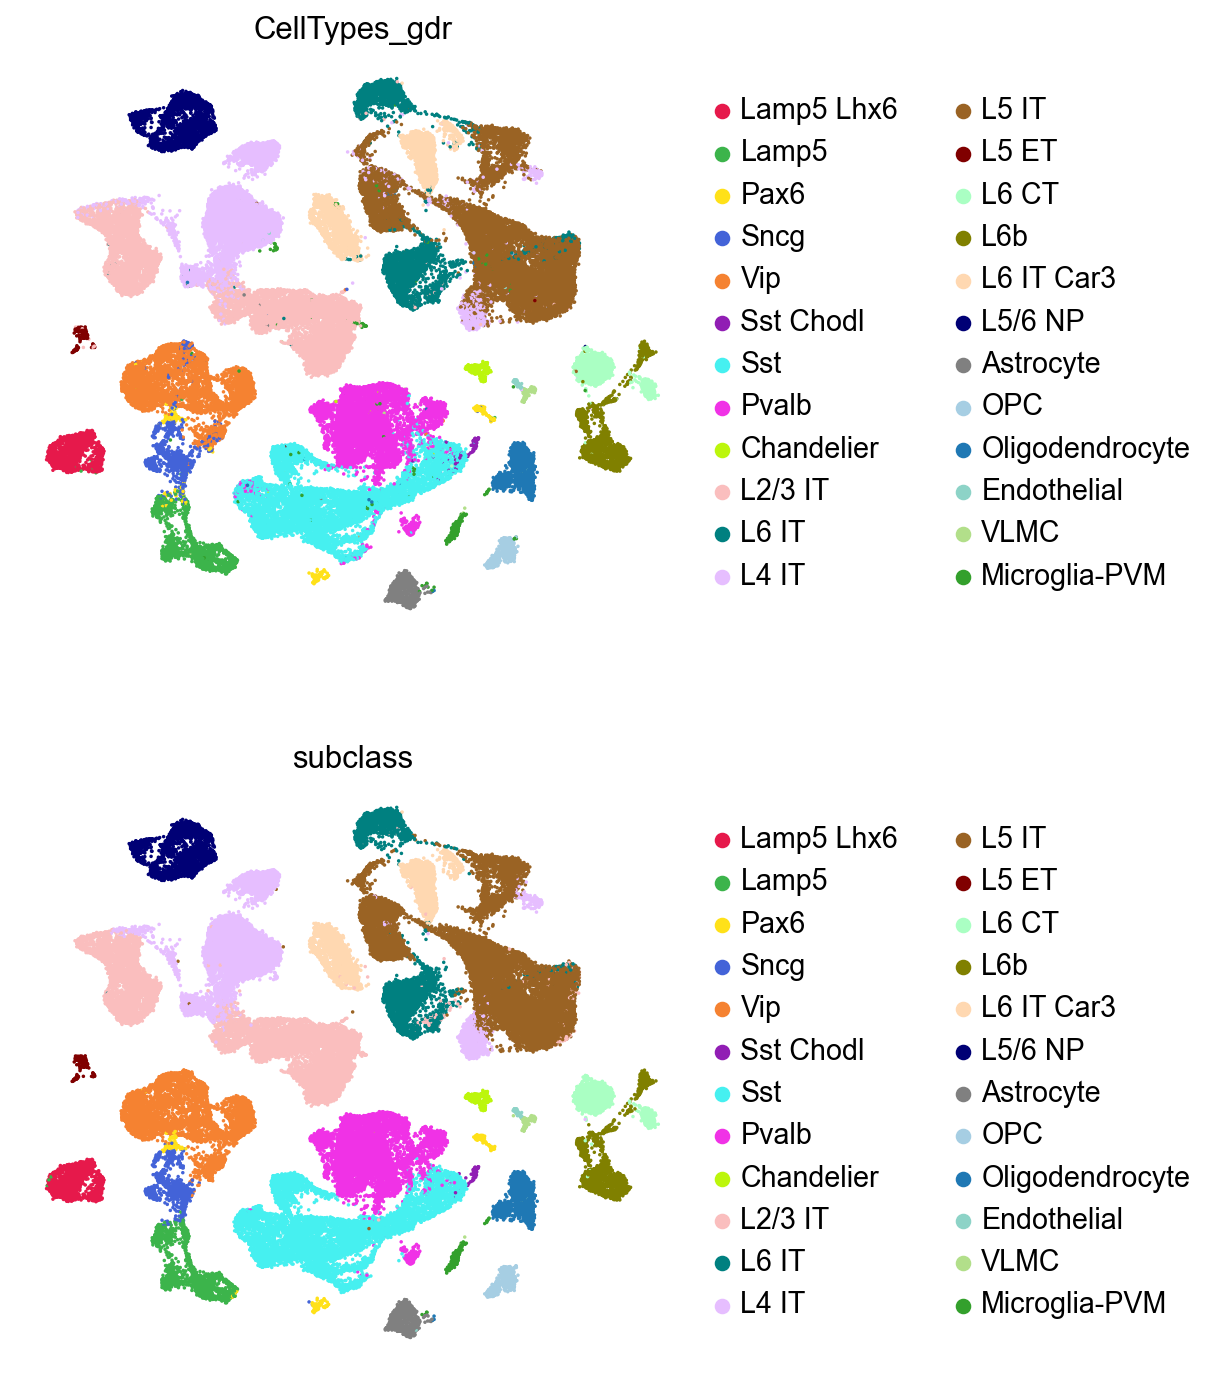

In [15]:
sc.pl.embedding(aibs_query_adata,
                basis='X_umap',
                color=['CellTypes_gdr', 'subclass'],
                palette=piaso.pl.color.d_color4,
                cmap=piaso.pl.color.c_color3,
                ncols=1,
                size=10,
                frameon=False)

Since we know the real subclass of the test data, we can test the performance of predictCellTypeByGDR by comparing predicted celltypes and true subclasses.

In [16]:
confusion_matrix = metrics.confusion_matrix(aibs_query_adata.obs['subclass'].values, aibs_query_adata.obs['CellTypes_gdr'].values)
confusion_matrix_df = pd.DataFrame(confusion_matrix, columns=aibs_query_adata.obs['subclass'].cat.categories, index=aibs_query_adata.obs['subclass'].cat.categories)

In [17]:
normalized_cf_matrix_df = confusion_matrix_df/confusion_matrix_df.sum(axis=0)

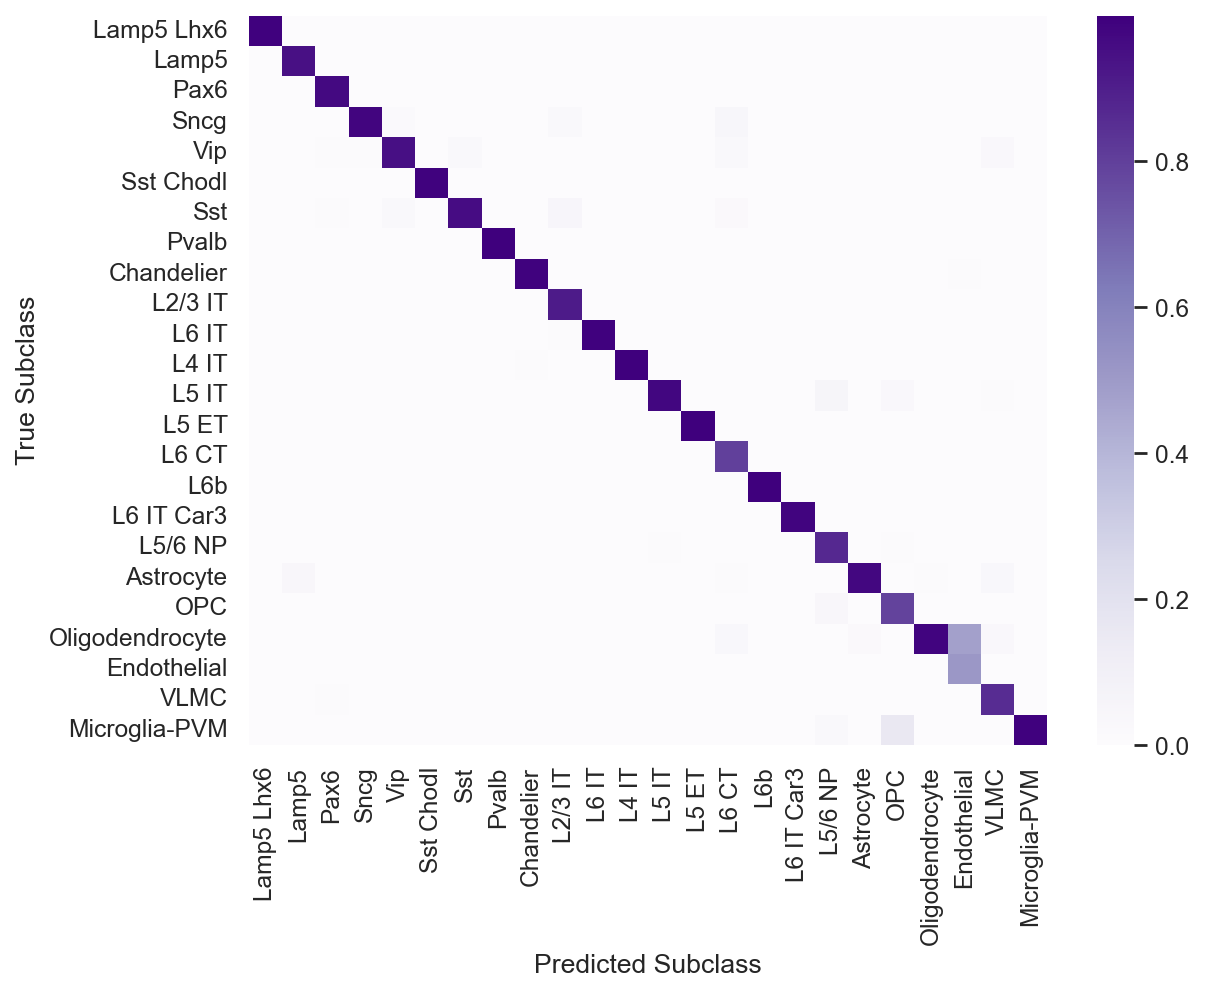

In [18]:
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set(rc={'figure.figsize':(8, 6)})
sns.heatmap(normalized_cf_matrix_df,
            cmap="Purples",
            xticklabels=True,
            yticklabels=True)
plt.xlabel("Predicted Subclass")
plt.ylabel("True Subclass")
plt.show()